In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
data = pd.read_excel('../data/data.xlsx')
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
data = data.set_index('Unnamed: 0')
data.index.name = None
data_pct = data.pct_change(1).dropna(axis=0)
data_pct.head()

,AAPL,MSFT,NVDA,AMZN,GOOG,META,BRK-B,TSLA,AVGO,WMT,...,SBER,ROSN,BTC-USD,GC%3DF,SI%3DF,PL%3DF,HG%3DF,PA%3DF,CL%3DF,NG%3DF
2016-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.002063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.007907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.007163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-05,-0.025059,0.004562,0.016064,-0.005024,0.000998,0.004989,0.003824,0.000090,-0.033455,0.023756,...,0.008979,0.008765,-0.002611,0.003070,0.009553,0.006114,0.008694,-0.014458,-0.021491,-0.003856
2016-01-06,-0.019570,-0.018165,-0.041350,-0.001799,0.001400,0.002336,0.000610,-0.019648,-0.030759,0.010013,...,-0.020629,-0.003160,-0.006609,0.012519,0.000573,-0.016768,-0.003831,-0.056158,-0.055602,-0.024946


In [3]:
#data slicer
indmin = data_pct.groupby(data_pct.index.to_period('M')).apply(lambda x: x.index.min()).values
indmax = data_pct.groupby(data_pct.index.to_period('M')).apply(lambda x: x.index.max()).values

#itg lists with frames
dfs = []

for i in range(0, 61):
    #data slicer
    pre = data_pct.loc[indmin[i]:indmax[i+11]]
    if len(pre) == 366:
        pre = pre[1:]
    dfs.append(pre)
    
dfs = dfs[:-29]

In [4]:
x = []
y = []
for i in range(0, len(dfs)-1):
    x.append(dfs[i].values.astype(np.float32))
    y.append(dfs[i+1][:30].values.astype(np.float32))

In [5]:
X_train = x[:21]
X_test = x[21:]

y_train = y[:21]
y_test = y[21:]

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(21, 10, 21, 10)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
X_train_loader = torch.utils.data.DataLoader(X_train, batch_size=1)
X_test_loader = torch.utils.data.DataLoader(X_test, batch_size=1)
y_train_loader = torch.utils.data.DataLoader(y_train, batch_size=1)
y_test_loader = torch.utils.data.DataLoader(y_test, batch_size=1)

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

input_size = 200
hidden_size = 256
num_layers = 2
output_size = 200
preq_len = 30

epochs = 10
learning_rate = 0.00001

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, preq_len):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.preq_len = preq_len
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None, c0=None):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -preq_len:, :]
        out = self.fc(out)
        return out

In [10]:
model = LSTMModel(input_size, hidden_size, num_layers, input_size, preq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
from tqdm import tqdm

In [12]:
loss_fn = F.mse_loss

train_losses = []
test_losses = []

for epoch in tqdm(range(epochs)):
    #train
    model.train()
    train_losses_per_epoch = []
    for X, Y in zip(X_train_loader, y_train_loader):
        optimizer.zero_grad()
        X_pred = model(X.to(device))

        loss = loss_fn(X_pred, Y.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_losses.append(np.mean(train_losses_per_epoch))

    #valuation
    model.eval()
    test_losses_per_epoch = []
    with torch.no_grad():
        for X, Y in zip(X_test_loader, y_test_loader):
            X_pred = model(X.to(device))

            loss = loss_fn(X_pred, Y.to(device))
            test_losses_per_epoch.append(loss.item())
    test_losses.append(np.mean(test_losses_per_epoch))

100%|██████████| 10/10 [00:59<00:00,  5.99s/it]


In [13]:
from matplotlib import pyplot as plt

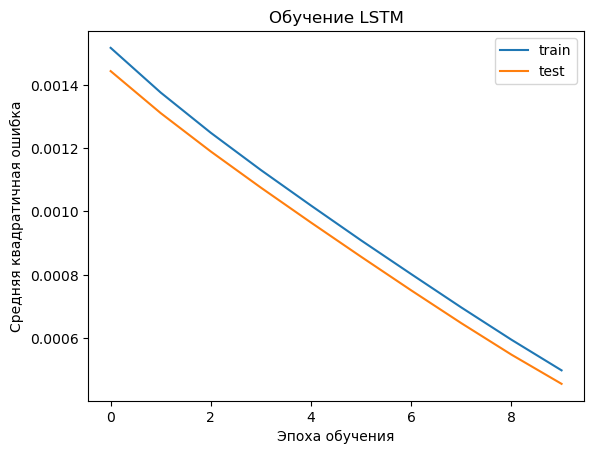

In [14]:
fig, ax = plt.subplots()

ax.plot(range(epochs), train_losses, label='train')
ax.plot(range(epochs), test_losses, label='test')
ax.set_title('Обучение LSTM')
ax.set_xlabel('Эпоха обучения',  fontsize = 10)
ax.set_ylabel('Средняя квадратичная ошибка', fontsize = 10)
plt.legend(['train', 'test'])
plt.show()

In [16]:
torch.save(model.state_dict(), 'lstm_predict.pth')